In [ ]:
%%capture
# Run preprocess_models.ipynb to create preprocessed data (if not already done)
%run ../preprocess_models.ipynb

# Mixture Model

This notebook continues from `models.ipynb` and applies a mixture model approach to classify insurance claims.

**Prerequisites:** Run `models.ipynb` first to create the preprocessed data and train/test splits.

In [93]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the preprocessed data from preprocess_models.ipynb
# All data is saved in data/processed/ after running preprocess_models.ipynb

df = pd.read_csv('../../data/processed/df_preprocessed.csv')
X_train = pd.read_csv('../../data/processed/X_train.csv')
X_test = pd.read_csv('../../data/processed/X_test.csv')
y_train = pd.read_csv('../../data/processed/y_train.csv').squeeze()
y_test = pd.read_csv('../../data/processed/y_test.csv').squeeze()

# split train set into train and validation sets, 15-85 split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


print("✓ Loaded preprocessed data from data/processed/")
print(f"\nData shape: {df.shape}")
print(f"Train set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\n✓ Ready for mixture model!")

✓ Loaded preprocessed data from data/processed/

Data shape: (9912, 18)
Train set: 7136 samples, 17 features
Validation set: 793 samples
Test set: 1983 samples

✓ Ready for mixture model!


## Step 1: Unified Preprocessing Pipeline

We consolidate **all** preprocessing steps into a single pipeline:
1. **Two-part encoding** for zero-inflated count features (PAST_ACCIDENTS, SPEEDING_VIOLATIONS, DUIS): I(X>0) and log(1+X)
2. **One-hot encoding** for categorical variables
3. **Standardization** for all continuous features

This produces **one unified feature matrix** that feeds directly into the GMM.

In [94]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import os

print("=" * 70)
print("UNIFIED PREPROCESSING PIPELINE")
print("=" * 70)

# ============================================================================
# STEP 1: TWO-PART ENCODING FOR ZERO-INFLATED COUNT FEATURES
# ============================================================================
print("\n[STEP 1] Two-part encoding for zero-inflated count features")
print("-" * 70)

zero_inflated_features = ['PAST_ACCIDENTS', 'SPEEDING_VIOLATIONS', 'DUIS']

# Create copies for transformation
X_train_prep = X_train.copy()
X_test_prep = X_test.copy()
X_val_prep = X_val.copy()

# Apply two-part encoding to both train and test
for feature in zero_inflated_features:
    if feature in X_train_prep.columns:
        # Training set
        X_train_prep[f'{feature}_occurred'] = (X_train_prep[feature] > 0).astype(int)
        X_train_prep[f'{feature}_log_magnitude'] = np.log1p(X_train_prep[feature])

        # Validation set
        X_val_prep[f'{feature}_occurred'] = (X_val_prep[feature] > 0).astype(int)
        X_val_prep[f'{feature}_log_magnitude'] = np.log1p(X_val_prep[feature])
        
        # Test set
        X_test_prep[f'{feature}_occurred'] = (X_test_prep[feature] > 0).astype(int)
        X_test_prep[f'{feature}_log_magnitude'] = np.log1p(X_test_prep[feature])
        
        # Print statistics
        n_zeros_train = (X_train[feature] == 0).sum()
        n_nonzeros_train = (X_train[feature] > 0).sum()
        pct_zeros_train = 100 * n_zeros_train / len(X_train)
        
        print(f"\n{feature}:")
        print(f"  Train - Zeros: {n_zeros_train} ({pct_zeros_train:.1f}%), Non-zeros: {n_nonzeros_train} ({100-pct_zeros_train:.1f}%)")
        print(f"  Train - Max: {X_train[feature].max()}, Mean (non-zero): {X_train[feature][X_train[feature] > 0].mean():.2f}")
        print(f"  Created: {feature}_occurred, {feature}_log_magnitude")
        
        # Drop original feature after transformation
        X_train_prep.drop(feature, axis=1, inplace=True)
        X_val_prep.drop(feature, axis=1, inplace=True)
        X_test_prep.drop(feature, axis=1, inplace=True)
        print(f"  Dropped original {feature}")

# ============================================================================
# STEP 2: ENCODE CATEGORICAL VARIABLES
# ============================================================================
print("\n[STEP 2] Encoding categorical variables")
print("-" * 70)

# Map binary/ordinal categorical variables to integers
categorical_mappings = {
    'GENDER': {'male': 0, 'female': 1},
    'RACE': {'majority': 0, 'minority': 1},
    'VEHICLE_YEAR': {'before 2015': 0, 'after 2015': 1},
    'VEHICLE_TYPE': {'sedan': 0, 'sports car': 1}}

for col, mapping in categorical_mappings.items():
    if col in X_train_prep.columns:
        X_train_prep[col] = X_train_prep[col].map(mapping).astype('int')
        X_val_prep[col] = X_val_prep[col].map(mapping).astype('int')
        X_test_prep[col] = X_test_prep[col].map(mapping).astype('int')
        print(f"  Mapped {col}: {mapping}")

# Handle POSTAL_CODE as categorical for one-hot encoding
if 'POSTAL_CODE' in X_train_prep.columns:
    X_train_prep['POSTAL_CODE'] = X_train_prep['POSTAL_CODE'].astype('category')
    X_val_prep['POSTAL_CODE'] = X_val_prep['POSTAL_CODE'].astype('category')
    X_test_prep['POSTAL_CODE'] = X_test_prep['POSTAL_CODE'].astype('category')
    print(f"  Set POSTAL_CODE as category for one-hot encoding")

# Apply one-hot encoding to remaining categorical variables
print("\n  Applying one-hot encoding...")
X_train_encoded = pd.get_dummies(X_train_prep, drop_first=True, dtype=int)
X_val_encoded = pd.get_dummies(X_val_prep, drop_first=True, dtype=int)
X_test_encoded = pd.get_dummies(X_test_prep, drop_first=True, dtype=int)

# Ensure train, val and test have the same columns (in case of missing categories in test)
X_val_encoded = X_val_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

print(f"  One-hot encoding complete: {X_train_encoded.shape[1]} features")

# ============================================================================
# STEP 3: STANDARDIZE/SCALE FEATURES (NUMERIC ONLY)
# ============================================================================
print("\n[STEP 3] Standardizing numeric features (zero mean, unit variance)")
print("-" * 70)

# Identify numeric columns to scale (continuous features only)
# Binary features (0/1) and one-hot encoded features should NOT be scaled
numeric_features = []
binary_features = []

for col in X_train_encoded.columns:
    # Check if column is binary (only contains 0 and 1)
    unique_vals = X_train_encoded[col].unique()
    if set(unique_vals).issubset({0, 1}):
        binary_features.append(col)
    else:
        numeric_features.append(col)

print(f"  Binary/One-hot features (not scaled): {len(binary_features)}")
print(f"    Examples: {binary_features[:5]}")
print(f"  Continuous numeric features (to be scaled): {len(numeric_features)}")
print(f"    {numeric_features}")

# Scale only the continuous numeric features
scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train_encoded[numeric_features])
X_val_numeric_scaled = scaler.transform(X_val_encoded[numeric_features])
X_test_numeric_scaled = scaler.transform(X_test_encoded[numeric_features])

# Create DataFrames for scaled numeric features
X_train_numeric_df = pd.DataFrame(X_train_numeric_scaled, columns=numeric_features, index=X_train_encoded.index)
X_val_numeric_df = pd.DataFrame(X_val_numeric_scaled, columns=numeric_features, index=X_val_encoded.index)
X_test_numeric_df = pd.DataFrame(X_test_numeric_scaled, columns=numeric_features, index=X_test_encoded.index)

# Keep binary features as-is (0/1 values)
X_train_binary_df = X_train_encoded[binary_features].copy()
X_val_binary_df = X_val_encoded[binary_features].copy()
X_test_binary_df = X_test_encoded[binary_features].copy()

# Combine scaled numeric + unscaled binary features
X_train_scaled_df = pd.concat([X_train_numeric_df, X_train_binary_df], axis=1)
X_val_scaled_df = pd.concat([X_val_numeric_df, X_val_binary_df], axis=1)
X_test_scaled_df = pd.concat([X_test_numeric_df, X_test_binary_df], axis=1)

# Reorder columns to match original order
X_train_scaled_df = X_train_scaled_df[X_train_encoded.columns]
X_val_scaled_df = X_val_scaled_df[X_val_encoded.columns]
X_test_scaled_df = X_test_scaled_df[X_test_encoded.columns]

# Convert to numpy arrays for GMM (maintaining column order)
X_train_scaled = X_train_scaled_df.values
X_val_scaled = X_val_scaled_df.values
X_test_scaled = X_test_scaled_df.values

print(f"  Fitted scaler on {len(numeric_features)} continuous features")
print(f"  Kept {len(binary_features)} binary features unscaled (0/1 values)")
print(f"  Final combined feature matrix: {X_train_scaled.shape[1]} features")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "=" * 70)
print("PREPROCESSING COMPLETE - UNIFIED FEATURE MATRIX READY")
print("=" * 70)
print(f"\nFinal feature space: {X_train_encoded.shape[1]} features")
print(f"Training set: {X_train_scaled.shape[0]} samples")
print(f"Test set: {X_test_scaled.shape[0]} samples")

print("\nFeature breakdown:")
print(f"  - Original numeric features: {len([c for c in X_train_encoded.columns if not any(zif in c for zif in zero_inflated_features) and 'POSTAL_CODE' not in c])}")
print(f"  - Zero-inflated transformations: {len([c for c in X_train_encoded.columns if any(zif in c for zif in zero_inflated_features)])} (from 3 features → {len([c for c in X_train_encoded.columns if any(zif in c for zif in zero_inflated_features)])})")
print(f"  - One-hot encoded features: {len([c for c in X_train_encoded.columns if 'POSTAL_CODE' in c])}")

print("\nComplete feature list:")
for i, feature in enumerate(X_train_encoded.columns, 1):
    print(f"  {i:2d}. {feature}")

# ============================================================================
# SAVE PREPROCESSED DATA
# ============================================================================
print("\n" + "=" * 70)
print("SAVING FULLY PREPROCESSED DATA (AFTER ALL TRANSFORMATIONS)")
print("=" * 70)

# Create directory if it doesn't exist
output_dir = '../../data/edited'
os.makedirs(output_dir, exist_ok=True)

# Save fully preprocessed (scaled) data - this is the final model-ready data
train_output_path = os.path.join(output_dir, 'mix_models_data_train.csv')
val_output_path = os.path.join(output_dir, 'mix_models_data_val.csv')
test_output_path = os.path.join(output_dir, 'mix_models_data_test.csv')

X_train_scaled_df.to_csv(train_output_path, index=False)
X_val_scaled_df.to_csv(val_output_path, index=False)
X_test_scaled_df.to_csv(test_output_path, index=False)

print(f"\n✓ Saved fully preprocessed training data: {train_output_path}")
print(f"  Shape: {X_train_scaled_df.shape}")
print(f"  Includes: Two-part encoding + One-hot encoding + Standardization")

print(f"\n✓ Saved fully preprocessed validation data: {val_output_path}")
print(f"  Shape: {X_val_scaled_df.shape}")
print(f"  Includes: Two-part encoding + One-hot encoding + Standardization")

print(f"\n✓ Saved fully preprocessed test data: {test_output_path}")
print(f"  Shape: {X_test_scaled_df.shape}")
print(f"  Includes: Two-part encoding + One-hot encoding + Standardization")

print("\n✓ Ready for Gaussian Mixture Model!")


UNIFIED PREPROCESSING PIPELINE

[STEP 1] Two-part encoding for zero-inflated count features
----------------------------------------------------------------------

PAST_ACCIDENTS:
  Train - Zeros: 4012 (56.2%), Non-zeros: 3124 (43.8%)
  Train - Max: 15, Mean (non-zero): 2.41
  Created: PAST_ACCIDENTS_occurred, PAST_ACCIDENTS_log_magnitude
  Dropped original PAST_ACCIDENTS

SPEEDING_VIOLATIONS:
  Train - Zeros: 3569 (50.0%), Non-zeros: 3567 (50.0%)
  Train - Max: 22, Mean (non-zero): 3.02
  Created: SPEEDING_VIOLATIONS_occurred, SPEEDING_VIOLATIONS_log_magnitude
  Dropped original SPEEDING_VIOLATIONS

DUIS:
  Train - Zeros: 5790 (81.1%), Non-zeros: 1346 (18.9%)
  Train - Max: 6, Mean (non-zero): 1.26
  Created: DUIS_occurred, DUIS_log_magnitude
  Dropped original DUIS

[STEP 2] Encoding categorical variables
----------------------------------------------------------------------
  Mapped GENDER: {'male': 0, 'female': 1}
  Mapped RACE: {'majority': 0, 'minority': 1}
  Mapped VEHICLE_YEAR:

## Step 2: Data Visualization & Feature Analysis

Now that we have our unified preprocessed dataset, let's visualize:
1. **PCA projection** to understand the overall data structure
2. **Zero-inflated features**: Distribution analysis before/after two-part encoding
3. **Remaining numeric features**: Q-Q plots and distributions to assess Gaussianity

PCA VISUALIZATION OF PREPROCESSED DATA

Full dataset: 9912 samples, 29 features
PCA explained variance ratio: [0.30095813 0.12417808]
Total variance explained by 2 components: 0.425


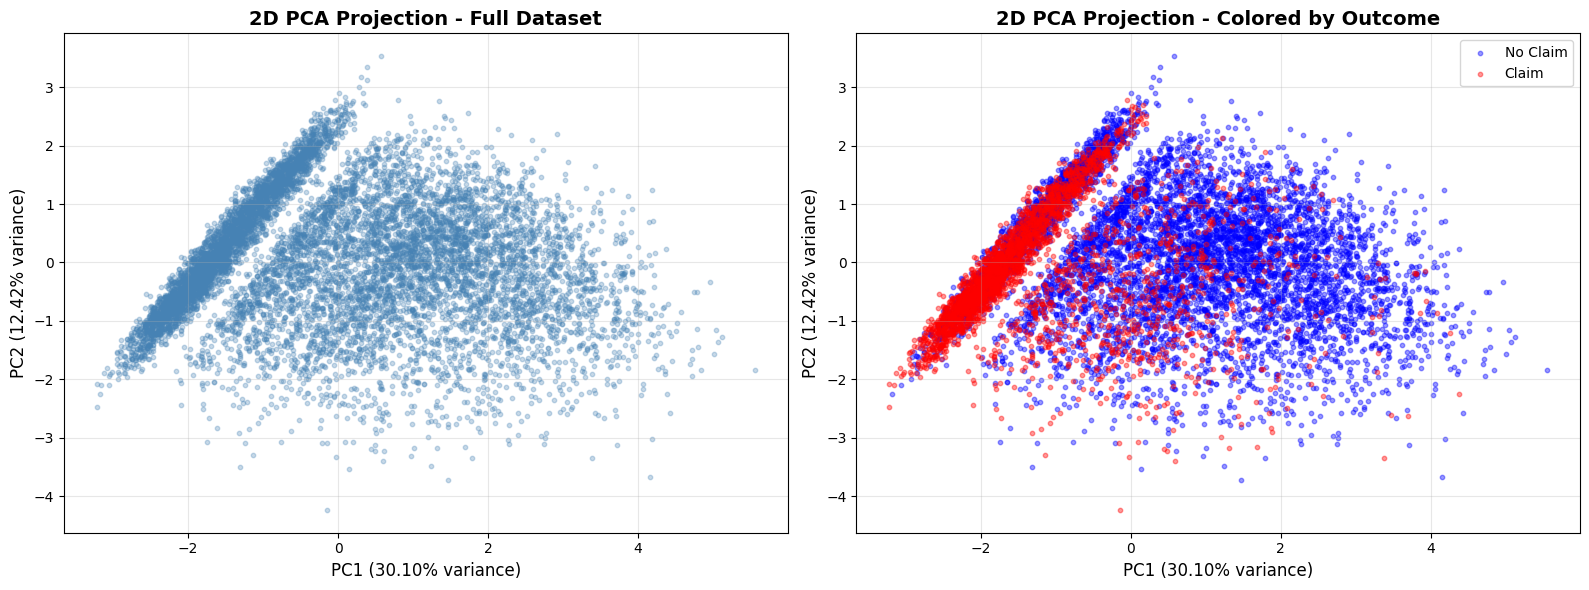


ZERO-INFLATED FEATURES: BEFORE vs AFTER TRANSFORMATION

Analyzing: PAST_ACCIDENTS


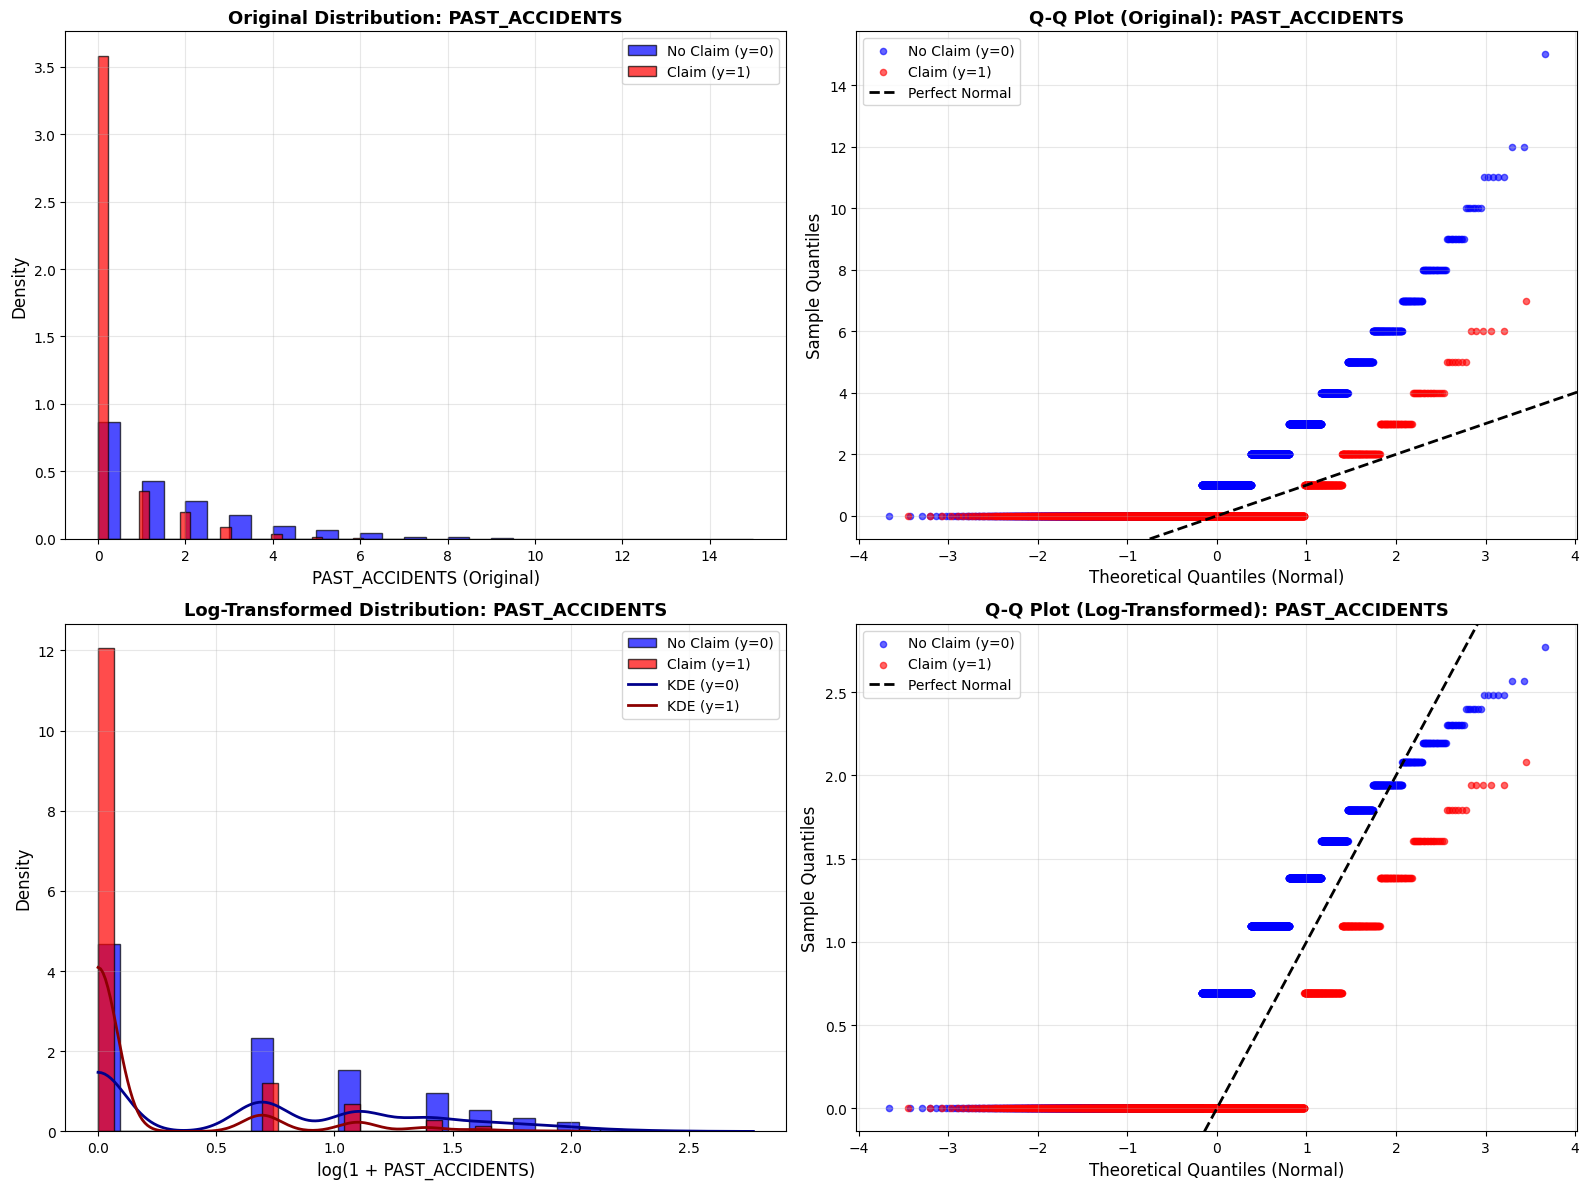

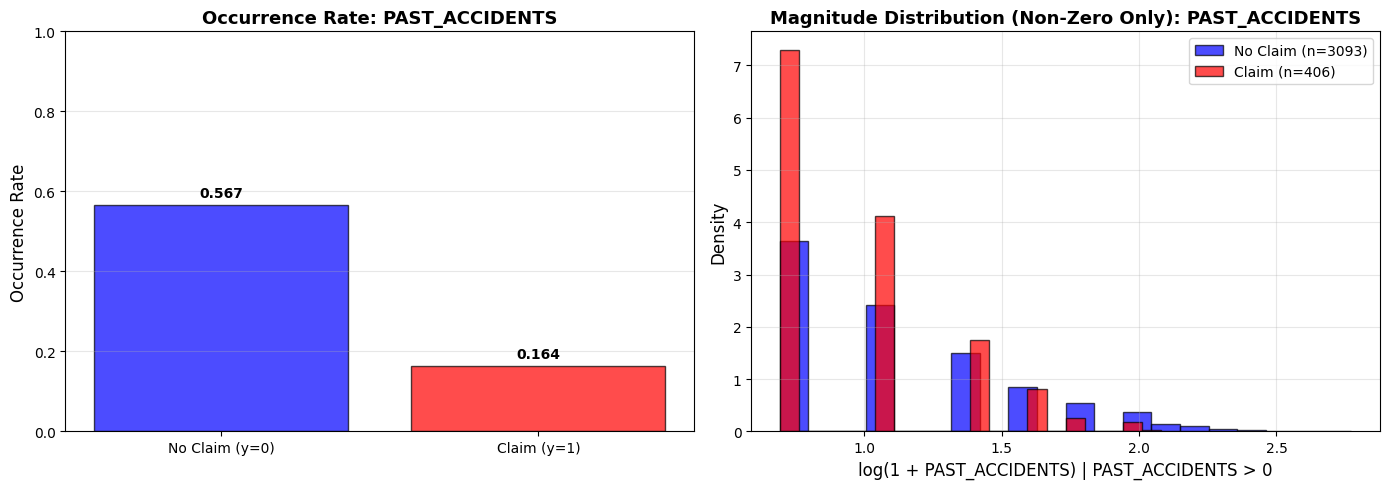


Analyzing: SPEEDING_VIOLATIONS


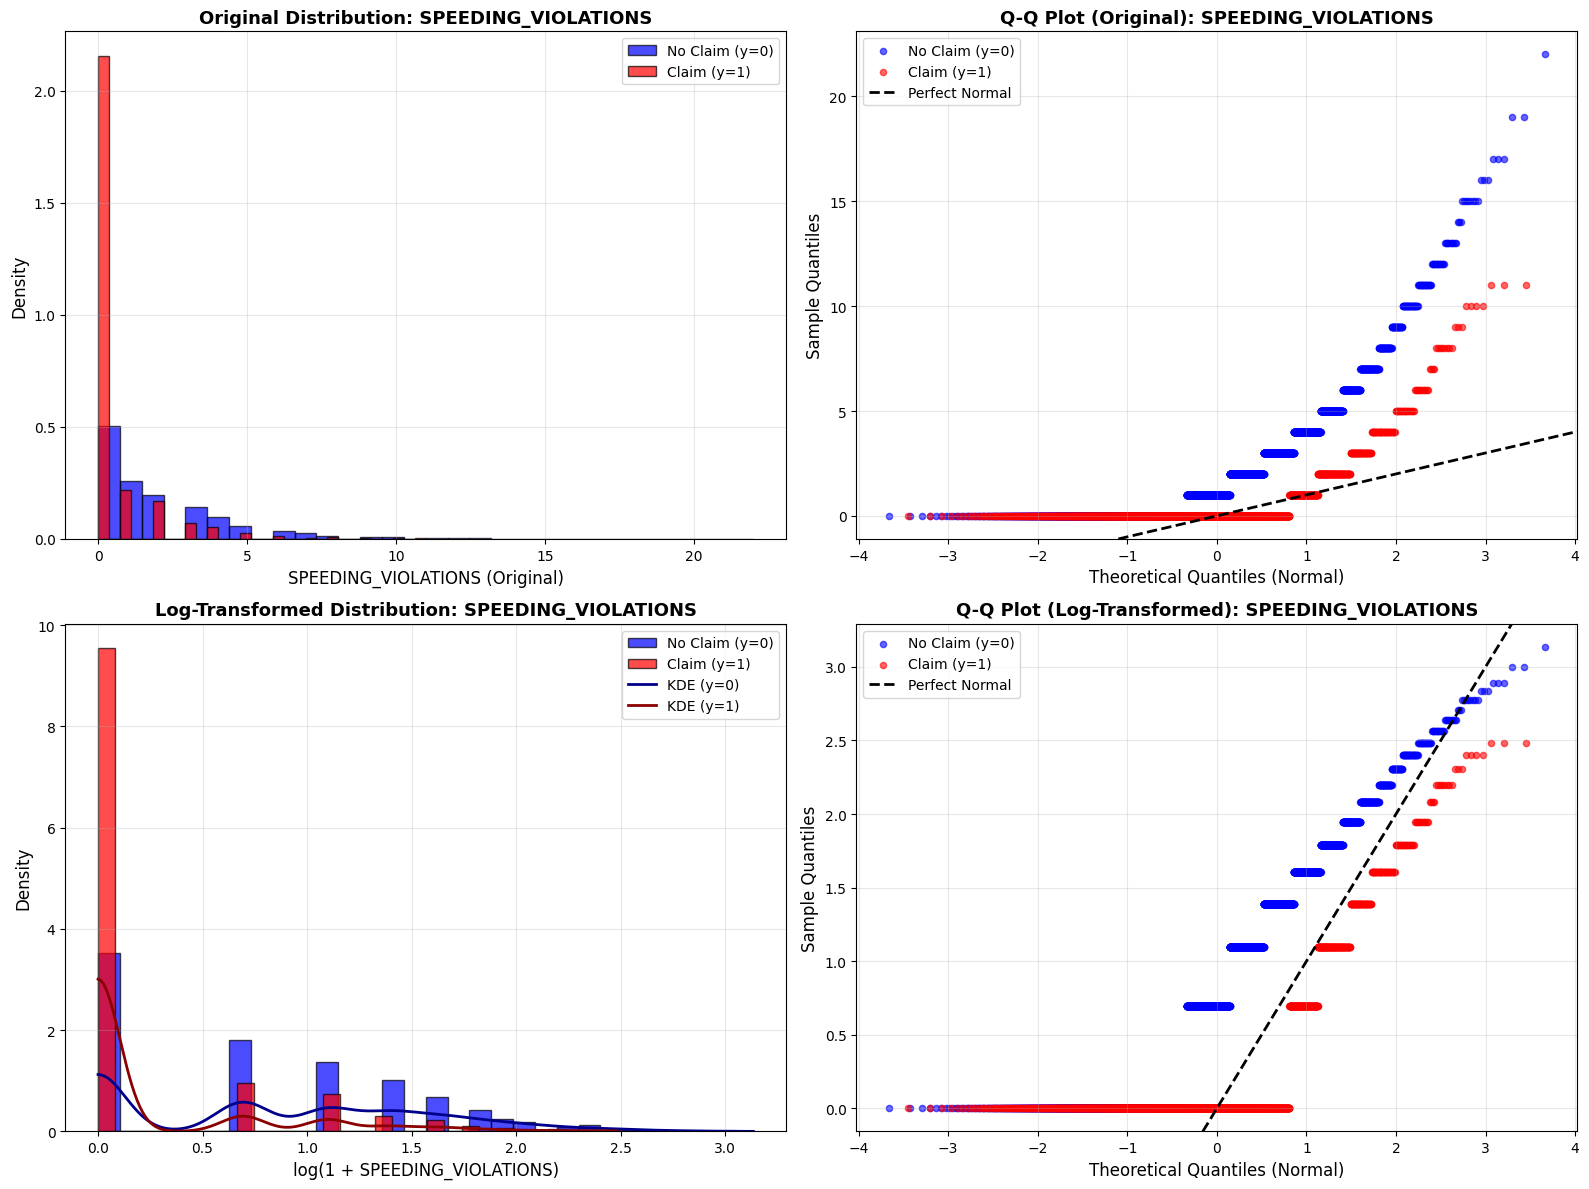

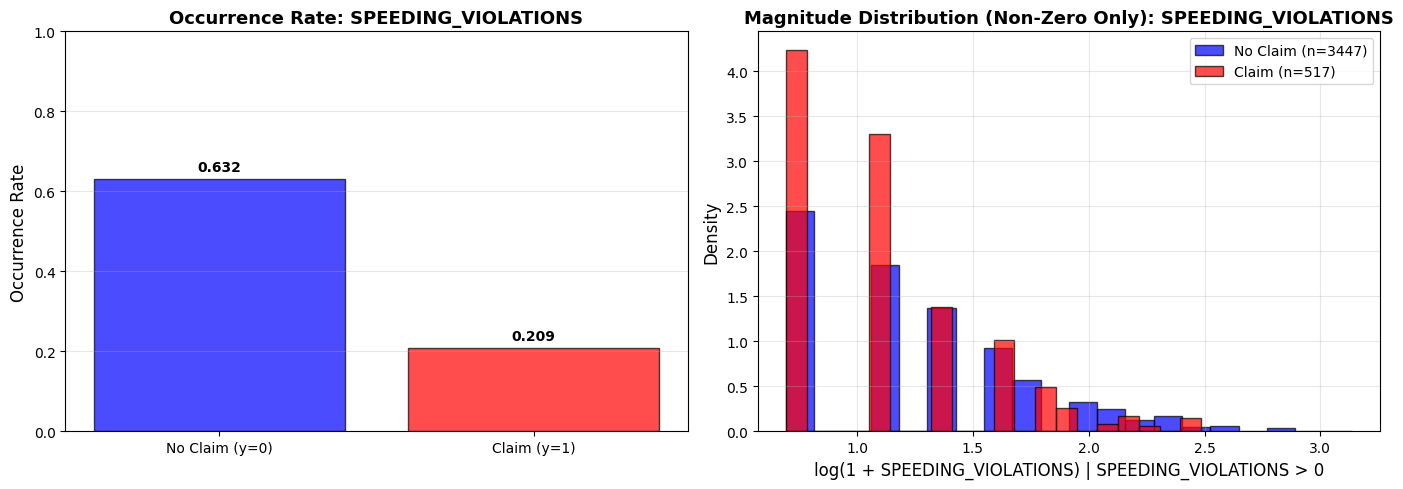


Analyzing: DUIS


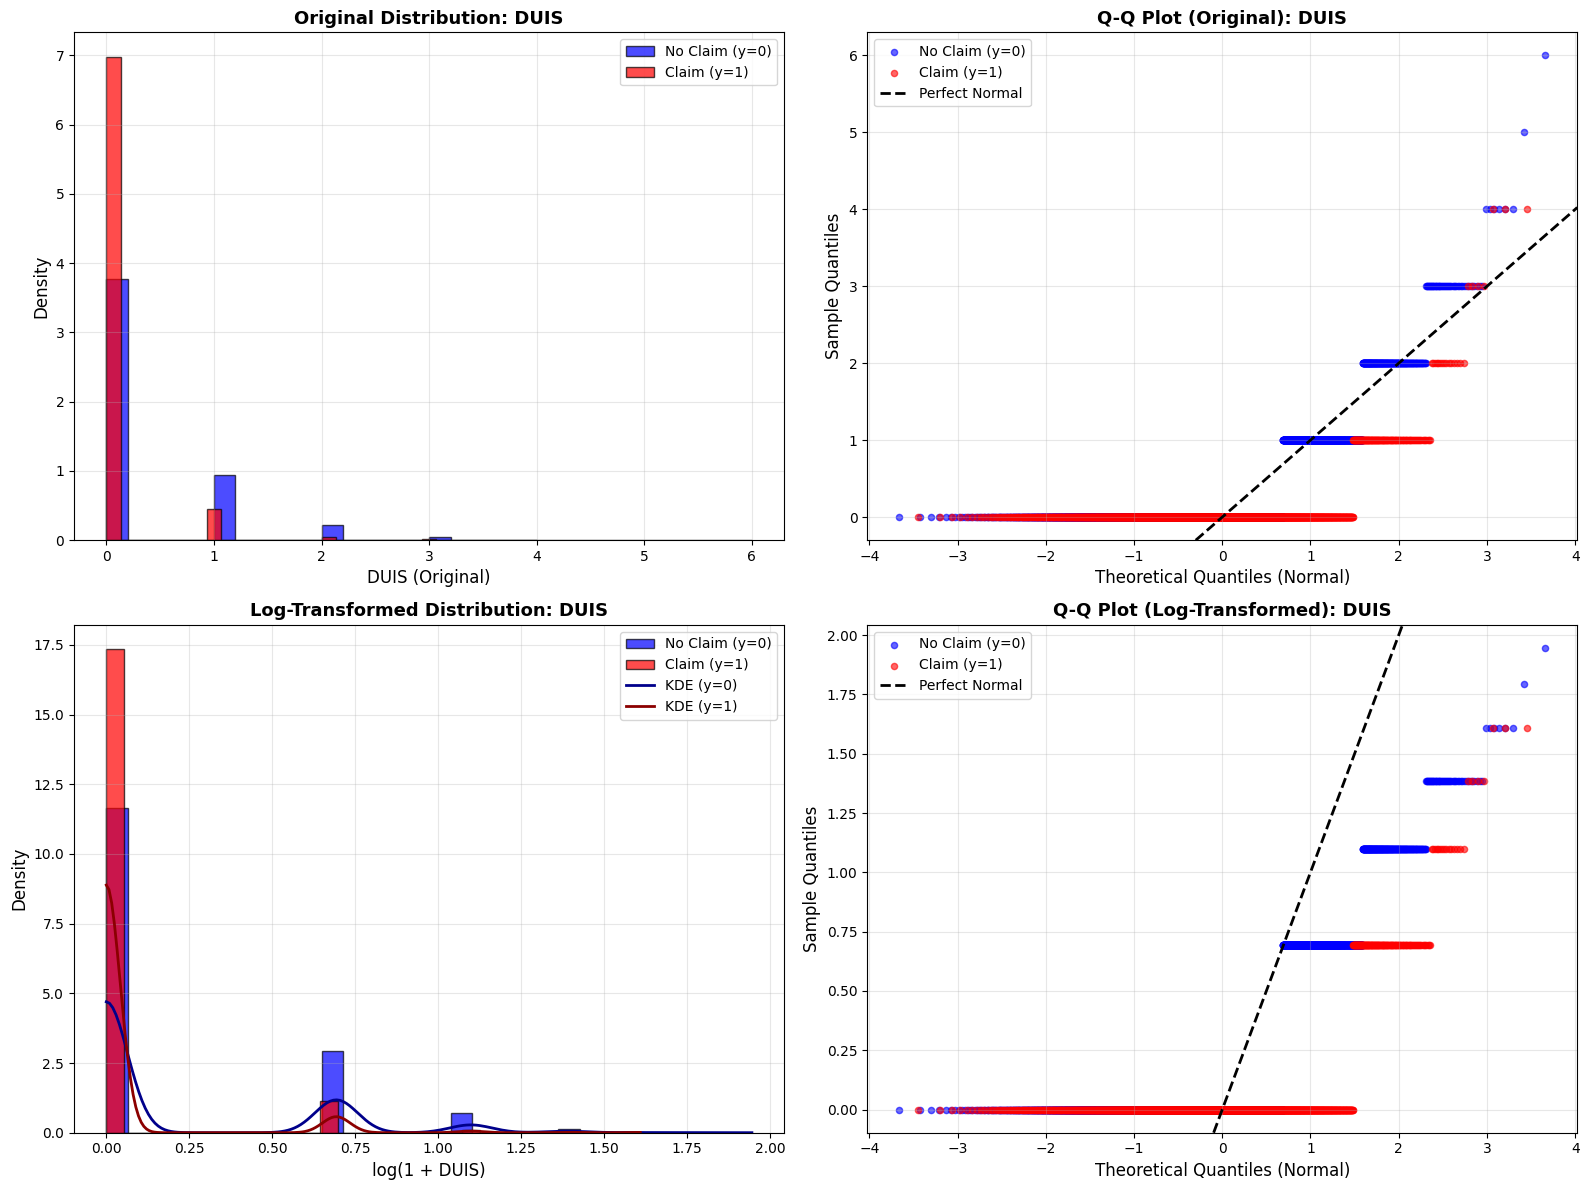

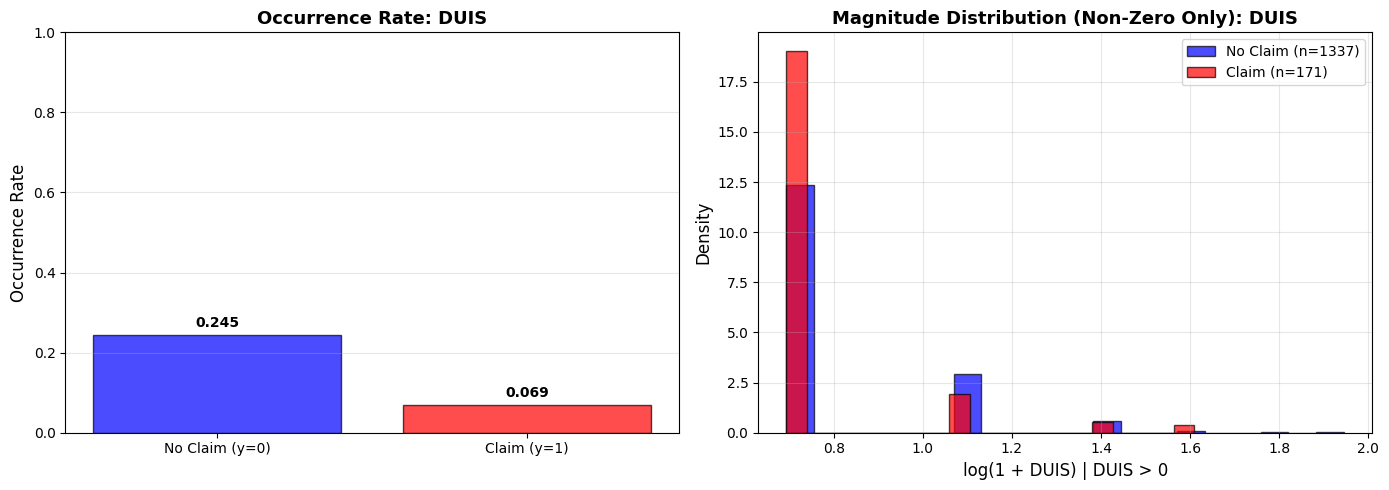


REMAINING NUMERIC FEATURES: NORMALITY ASSESSMENT

Analyzing 2 remaining numeric features: ['CREDIT_SCORE', 'ANNUAL_MILEAGE']


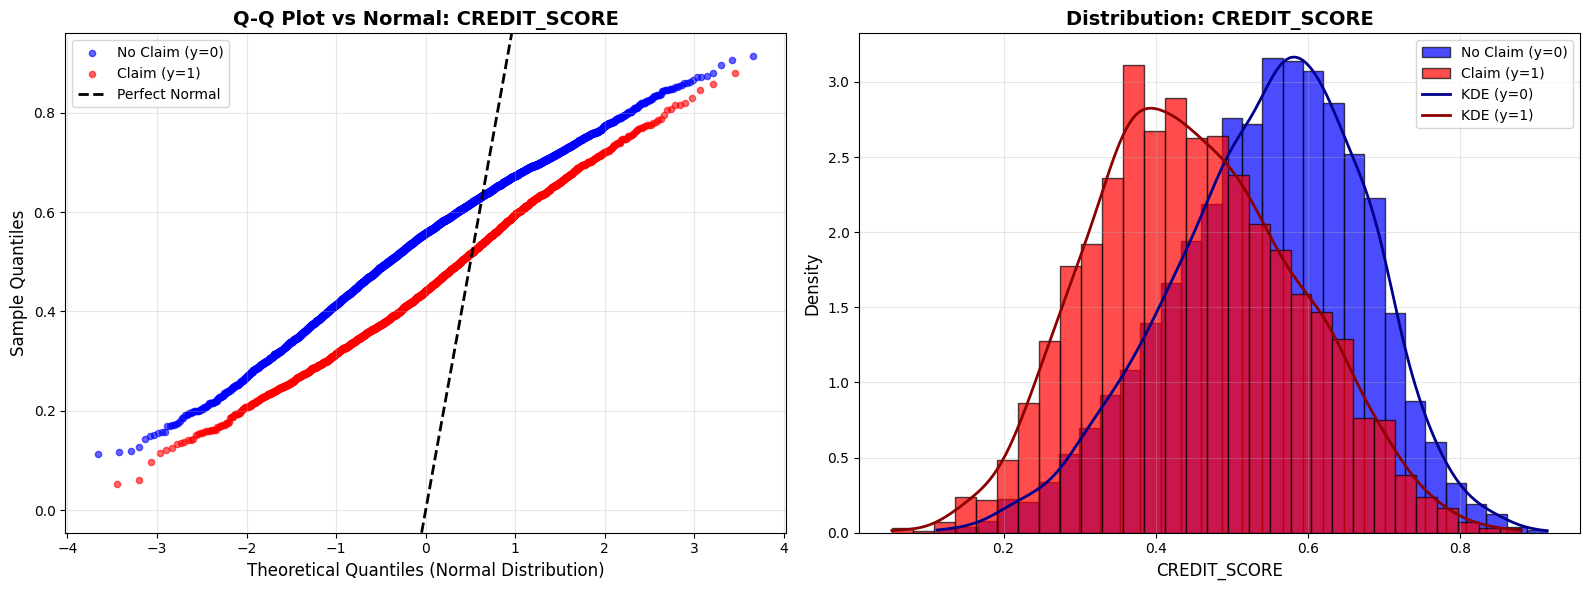

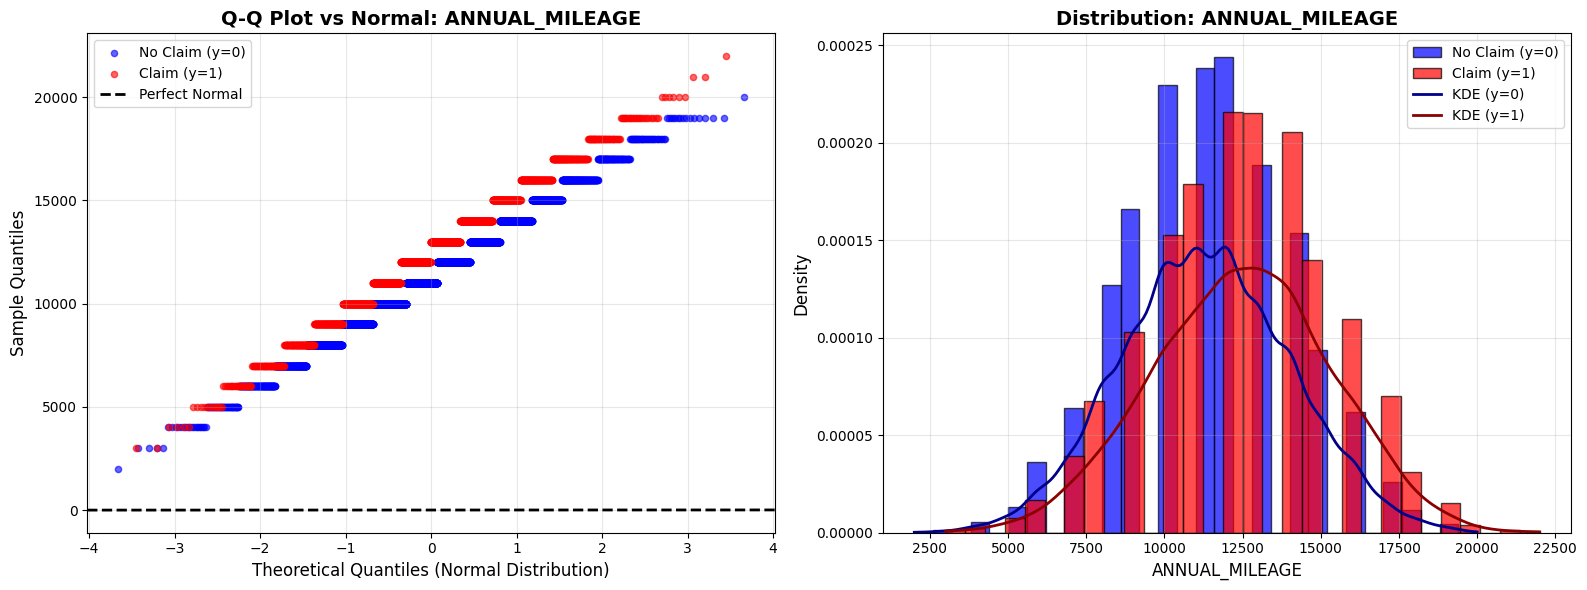


✓ Visualization complete!


In [53]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy import stats

# ============================================================================
# PART A: PCA VISUALIZATION
# ============================================================================
print("=" * 70)
print("PCA VISUALIZATION OF PREPROCESSED DATA")
print("=" * 70)

# Combine train and test sets for full dataset visualization
X_full_scaled = np.vstack([X_train_scaled, X_test_scaled])
y_full = pd.concat([y_train, y_test], axis=0, ignore_index=True)

# Apply PCA to reduce to 2D
pca = PCA(n_components=2, random_state=42)
X_full_2d = pca.fit_transform(X_full_scaled)

print(f"\nFull dataset: {X_full_scaled.shape[0]} samples, {X_full_scaled.shape[1]} features")
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained by 2 components: {pca.explained_variance_ratio_.sum():.3f}")

# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Plain scatter plot (overall structure)
axes[0].scatter(X_full_2d[:, 0], X_full_2d[:, 1], alpha=0.3, s=10, color='steelblue')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
axes[0].set_title('2D PCA Projection - Full Dataset', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Plot 2: Colored by target (claim vs. no claim)
colors = ['blue', 'red']
labels = ['No Claim', 'Claim']
for outcome in [0, 1]:
    mask = (y_full == outcome)
    axes[1].scatter(
        X_full_2d[mask, 0], 
        X_full_2d[mask, 1], 
        alpha=0.4, 
        s=10, 
        color=colors[outcome],
        label=labels[outcome]
    )
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
axes[1].set_title('2D PCA Projection - Colored by Outcome', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# PART B: ZERO-INFLATED FEATURES ANALYSIS
# ============================================================================
print("\n" + "=" * 70)
print("ZERO-INFLATED FEATURES: BEFORE vs AFTER TRANSFORMATION")
print("=" * 70)

zero_inflated_features = ['PAST_ACCIDENTS', 'SPEEDING_VIOLATIONS', 'DUIS']

for feature in zero_inflated_features:
    if feature not in X_train.columns:
        continue
    
    print(f"\nAnalyzing: {feature}")
    
    # Original data (before transformation)
    data_0_orig = X_train[y_train == 0][feature].dropna()
    data_1_orig = X_train[y_train == 1][feature].dropna()
    
    # Transformed data (after log transformation) - reconstruct for visualization
    data_0_log = np.log1p(X_train[y_train == 0][feature].dropna())
    data_1_log = np.log1p(X_train[y_train == 1][feature].dropna())
    
    # Binary indicator
    data_0_binary = (X_train[y_train == 0][feature] > 0).astype(int)
    data_1_binary = (X_train[y_train == 1][feature] > 0).astype(int)
    
    # Create 2x2 subplot: [Original vs Log-transformed] x [Histogram+KDE, Q-Q plot]
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Row 1: ORIGINAL FEATURE
    # Histogram for original
    axes[0, 0].hist(data_0_orig, bins=30, alpha=0.7, color='blue', density=True, 
                    label='No Claim (y=0)', edgecolor='black')
    axes[0, 0].hist(data_1_orig, bins=30, alpha=0.7, color='red', density=True, 
                    label='Claim (y=1)', edgecolor='black')
    axes[0, 0].set_xlabel(f'{feature} (Original)', fontsize=12)
    axes[0, 0].set_ylabel('Density', fontsize=12)
    axes[0, 0].set_title(f'Original Distribution: {feature}', fontsize=13, fontweight='bold')
    axes[0, 0].legend(loc='best')
    axes[0, 0].grid(alpha=0.3)
    
    # Q-Q plot for original (against Normal)
    if len(data_0_orig) > 1:
        res_0 = stats.probplot(data_0_orig, dist="norm", plot=None)
        axes[0, 1].scatter(res_0[0][0], res_0[0][1], alpha=0.6, s=20, color='blue', label='No Claim (y=0)')
    if len(data_1_orig) > 1:
        res_1 = stats.probplot(data_1_orig, dist="norm", plot=None)
        axes[0, 1].scatter(res_1[0][0], res_1[0][1], alpha=0.6, s=20, color='red', label='Claim (y=1)')
    axes[0, 1].axline((0, 0), slope=1, color='black', linestyle='--', lw=2, label='Perfect Normal')
    axes[0, 1].set_xlabel('Theoretical Quantiles (Normal)', fontsize=12)
    axes[0, 1].set_ylabel('Sample Quantiles', fontsize=12)
    axes[0, 1].set_title(f'Q-Q Plot (Original): {feature}', fontsize=13, fontweight='bold')
    axes[0, 1].legend(loc='best')
    axes[0, 1].grid(alpha=0.3)
    
    # Row 2: LOG-TRANSFORMED FEATURE
    # Histogram + KDE for log-transformed
    axes[1, 0].hist(data_0_log, bins=30, alpha=0.7, color='blue', density=True, 
                    label='No Claim (y=0)', edgecolor='black')
    axes[1, 0].hist(data_1_log, bins=30, alpha=0.7, color='red', density=True, 
                    label='Claim (y=1)', edgecolor='black')
    
    # Add KDE
    from scipy.stats import gaussian_kde
    if len(data_0_log) > 1:
        kde_0 = gaussian_kde(data_0_log)
        x_range = np.linspace(data_0_log.min(), data_0_log.max(), 200)
        axes[1, 0].plot(x_range, kde_0(x_range), color='darkblue', lw=2, label='KDE (y=0)')
    if len(data_1_log) > 1:
        kde_1 = gaussian_kde(data_1_log)
        x_range = np.linspace(data_1_log.min(), data_1_log.max(), 200)
        axes[1, 0].plot(x_range, kde_1(x_range), color='darkred', lw=2, label='KDE (y=1)')
    
    axes[1, 0].set_xlabel(f'log(1 + {feature})', fontsize=12)
    axes[1, 0].set_ylabel('Density', fontsize=12)
    axes[1, 0].set_title(f'Log-Transformed Distribution: {feature}', fontsize=13, fontweight='bold')
    axes[1, 0].legend(loc='best')
    axes[1, 0].grid(alpha=0.3)
    
    # Q-Q plot for log-transformed (against Normal)
    if len(data_0_log) > 1:
        res_0_log = stats.probplot(data_0_log, dist="norm", plot=None)
        axes[1, 1].scatter(res_0_log[0][0], res_0_log[0][1], alpha=0.6, s=20, color='blue', label='No Claim (y=0)')
    if len(data_1_log) > 1:
        res_1_log = stats.probplot(data_1_log, dist="norm", plot=None)
        axes[1, 1].scatter(res_1_log[0][0], res_1_log[0][1], alpha=0.6, s=20, color='red', label='Claim (y=1)')
    axes[1, 1].axline((0, 0), slope=1, color='black', linestyle='--', lw=2, label='Perfect Normal')
    axes[1, 1].set_xlabel('Theoretical Quantiles (Normal)', fontsize=12)
    axes[1, 1].set_ylabel('Sample Quantiles', fontsize=12)
    axes[1, 1].set_title(f'Q-Q Plot (Log-Transformed): {feature}', fontsize=13, fontweight='bold')
    axes[1, 1].legend(loc='best')
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Visualize binary indicator (occurrence rate by class)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar plot of occurrence rates
    occurrence_rates = [data_0_binary.mean(), data_1_binary.mean()]
    classes = ['No Claim (y=0)', 'Claim (y=1)']
    colors_bar = ['blue', 'red']
    
    axes[0].bar(classes, occurrence_rates, color=colors_bar, alpha=0.7, edgecolor='black')
    axes[0].set_ylabel('Occurrence Rate', fontsize=12)
    axes[0].set_title(f'Occurrence Rate: {feature}', fontsize=13, fontweight='bold')
    axes[0].set_ylim([0, 1])
    axes[0].grid(alpha=0.3, axis='y')
    for i, v in enumerate(occurrence_rates):
        axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
    
    # Distribution of log magnitude (non-zero values only)
    data_0_nonzero = X_train[(y_train == 0) & (X_train[feature] > 0)][feature].dropna()
    data_1_nonzero = X_train[(y_train == 1) & (X_train[feature] > 0)][feature].dropna()
    
    if len(data_0_nonzero) > 0:
        axes[1].hist(np.log1p(data_0_nonzero), bins=20, alpha=0.7, color='blue', 
                     density=True, label=f'No Claim (n={len(data_0_nonzero)})', edgecolor='black')
    if len(data_1_nonzero) > 0:
        axes[1].hist(np.log1p(data_1_nonzero), bins=20, alpha=0.7, color='red', 
                     density=True, label=f'Claim (n={len(data_1_nonzero)})', edgecolor='black')
    
    axes[1].set_xlabel(f'log(1 + {feature}) | {feature} > 0', fontsize=12)
    axes[1].set_ylabel('Density', fontsize=12)
    axes[1].set_title(f'Magnitude Distribution (Non-Zero Only): {feature}', fontsize=13, fontweight='bold')
    axes[1].legend(loc='best')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# PART C: REMAINING NUMERIC FEATURES ANALYSIS
# ============================================================================
print("\n" + "=" * 70)
print("REMAINING NUMERIC FEATURES: NORMALITY ASSESSMENT")
print("=" * 70)

# Identify remaining numeric columns (exclude zero-inflated features)
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
excluded_cols = ['VEHICLE_OWNERSHIP', '', 'MARRIED', 'CHILDREN', 'POSTAL_CODE'] + zero_inflated_features

for col in excluded_cols:
    if col in numeric_cols:
        numeric_cols.remove(col)

print(f"\nAnalyzing {len(numeric_cols)} remaining numeric features: {numeric_cols}")

# Create Q-Q plots and Histogram+KDE for remaining numeric columns
for col in numeric_cols:
    # Get data for y=0 and y=1
    data_0 = X_train[y_train == 0][col].dropna()
    data_1 = X_train[y_train == 1][col].dropna()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Q-Q Plot against theoretical Normal distribution
    if len(data_0) > 1:
        res_0 = stats.probplot(data_0, dist="norm", plot=None)
        axes[0].scatter(res_0[0][0], res_0[0][1], alpha=0.6, s=20, color='blue', label='No Claim (y=0)')
    
    if len(data_1) > 1:
        res_1 = stats.probplot(data_1, dist="norm", plot=None)
        axes[0].scatter(res_1[0][0], res_1[0][1], alpha=0.6, s=20, color='red', label='Claim (y=1)')
    
    axes[0].axline((0, 0), slope=1, color='black', linestyle='--', lw=2, label='Perfect Normal')
    axes[0].set_xlabel('Theoretical Quantiles (Normal Distribution)', fontsize=12)
    axes[0].set_ylabel('Sample Quantiles', fontsize=12)
    axes[0].set_title(f'Q-Q Plot vs Normal: {col}', fontsize=14, fontweight='bold')
    axes[0].legend(loc='best')
    axes[0].grid(alpha=0.3)
    
    # Histogram + KDE
    axes[1].hist(data_0, bins=30, alpha=0.7, color='blue', density=True, label='No Claim (y=0)', edgecolor='black')
    axes[1].hist(data_1, bins=30, alpha=0.7, color='red', density=True, label='Claim (y=1)', edgecolor='black')
    
    # Add KDE
    from scipy.stats import gaussian_kde
    if len(data_0) > 1:
        kde_0 = gaussian_kde(data_0)
        x_range = np.linspace(data_0.min(), data_0.max(), 200)
        axes[1].plot(x_range, kde_0(x_range), color='darkblue', lw=2, label='KDE (y=0)')
    
    if len(data_1) > 1:
        kde_1 = gaussian_kde(data_1)
        x_range = np.linspace(data_1.min(), data_1.max(), 200)
        axes[1].plot(x_range, kde_1(x_range), color='darkred', lw=2, label='KDE (y=1)')
    
    axes[1].set_xlabel(col, fontsize=12)
    axes[1].set_ylabel('Density', fontsize=12)
    axes[1].set_title(f'Distribution: {col}', fontsize=14, fontweight='bold')
    axes[1].legend(loc='best')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("\n✓ Visualization complete!")


## Step 3: Correlation Analysis

Examine the correlation structure of the preprocessed features to identify potential multicollinearity.

Correlation matrix computed for 29 features
Displaying correlations >= 0.45 or <= -0.45


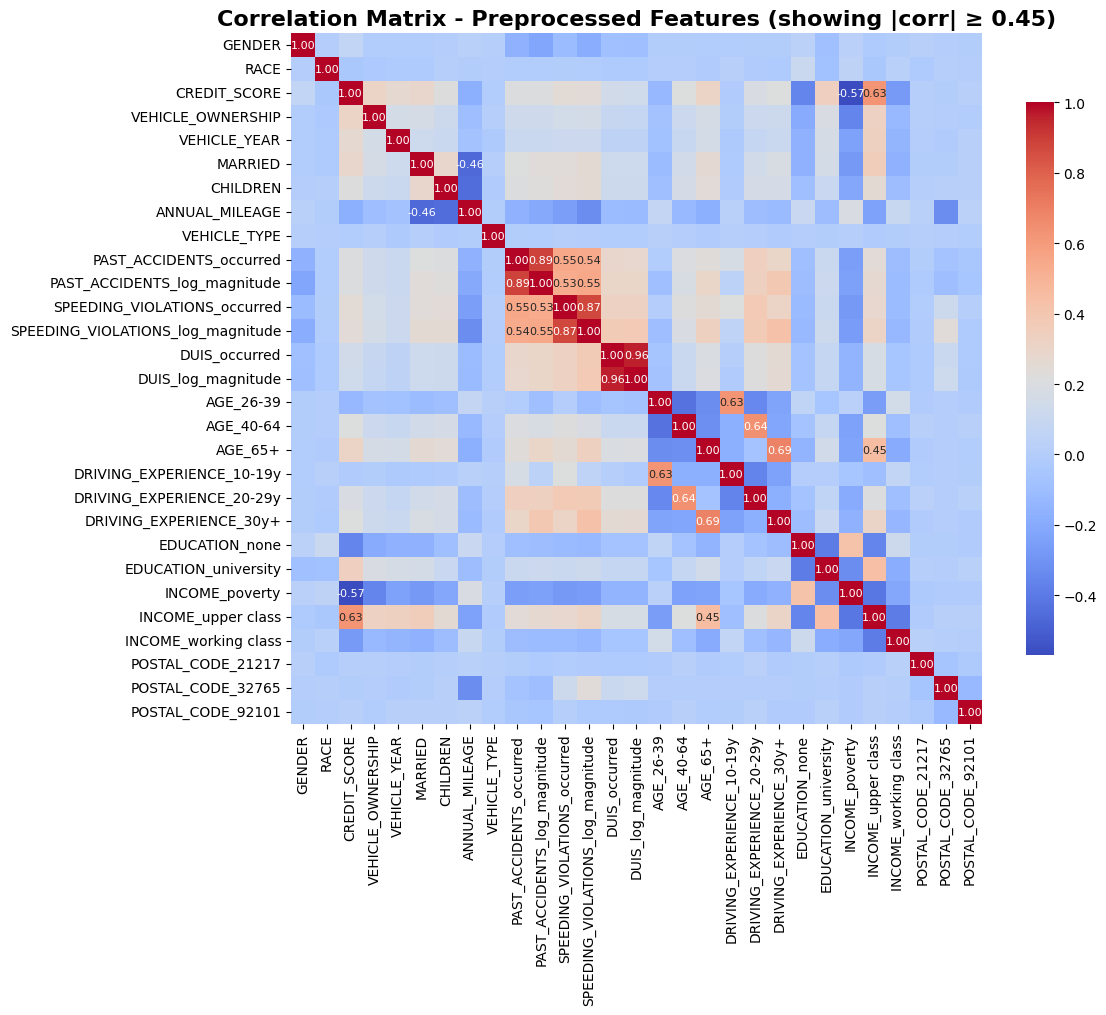

In [95]:
# Correlation matrix on the preprocessed scaled data
import seaborn as sns
import matplotlib.pyplot as plt

# Convert scaled array to DataFrame for correlation calculation
X_full_scaled_combined = np.vstack([X_train_scaled, X_test_scaled])
X_full_scaled_df = pd.DataFrame(X_full_scaled_combined, columns=X_train_encoded.columns)

# Control thresholds for displaying correlation values
corr_threshold_high = 0.45  # Show correlations >= this value (strong positive)
corr_threshold_low = -0.45  # Show correlations <= this value (strong negative)

print(f"Correlation matrix computed for {X_full_scaled_df.shape[1]} features")
print(f"Displaying correlations >= {corr_threshold_high} or <= {corr_threshold_low}")

plt.figure(figsize=(12, 10))
correlation_matrix = X_full_scaled_df.corr()

# Create annotation mask: show values above high threshold OR below low threshold
mask_annotations = (correlation_matrix >= corr_threshold_high) | (correlation_matrix <= corr_threshold_low)

# Create a mask array for seaborn - True means hide the annotation
mask_for_annot = ~mask_annotations.values

# Create annotations - use empty string where mask is True
annot_data = correlation_matrix.values.copy()
annot_labels = np.empty_like(annot_data, dtype=object)
for i in range(annot_data.shape[0]):
    for j in range(annot_data.shape[1]):
        if mask_for_annot[i, j]:
            annot_labels[i, j] = ''
        else:
            annot_labels[i, j] = f'{annot_data[i, j]:.2f}'

sns.heatmap(correlation_matrix, annot=annot_labels, fmt='', cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .8}, annot_kws={"size": 8})
plt.title(f'Correlation Matrix - Preprocessed Features (showing |corr| ≥ {corr_threshold_high})', 
          fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## Step 4: Fit Gaussian Mixture Model

Now we train the GMM on the **unified preprocessed feature matrix** from Step 1. We'll start with K=3 components to discover latent risk groups in our population.

In [96]:
def fit_GMM(X_train_scaled, n_components=2, covariance_type='full', reg_covariance=1e-6, verbose=False):
    """Fit Gaussian Mixture Model to the training data and display component sizes."""

    # Fit Gaussian Mixture Model with K=3 components
    n_components = n_components
    gmm = GaussianMixture(
        n_components=n_components,
        covariance_type=covariance_type,  # 'full', 'tied', 'diag', 'spherical'
        reg_covar=reg_covariance,  # Regularization to ensure positive-definite covariances
        random_state=42,
        n_init=10  # Multiple initializations for stability
    )

    gmm.fit(X_train_scaled)

    # Get component assignments for training data
    train_component_probs = gmm.predict_proba(X_train_scaled)  # Posterior probabilities
    train_components = gmm.predict(X_train_scaled)  # Hard assignments

    # print(train_component_probs[188:195])
    # print(train_components[188:195])
    if verbose:
        print(f"Fitted GMM with {n_components} components")
        print(f"\nComponent sizes in training set:")
        for k in range(n_components):
            count = np.sum(train_components == k)
            pct = 100 * count / len(train_components)
            print(f"  Component {k}: {count} samples ({pct:.1f}%)")

        print(f"\nDoes the GMM converge? {gmm.converged_}\nnumber of iterations: {gmm.n_iter_}\n")

    return gmm, train_component_probs, train_components

## Step 3: Compute Component-Level Claim Probabilities

For each component, calculate the empirical claim rate (P(Y=1|component=k)) based on training data.

In [97]:
def calculate_component_claim_probabilities(y_train, train_component_probs, train_components, n_components, verbose=False):

    # Calculate claim probability for each component
    y_train_array = y_train.values 
    component_claim_probs_hard = np.zeros(n_components)
    component_claim_probs_soft = np.zeros(n_components)

    for k in range(n_components):
        # Hard assignments
        mask_hard = (train_components == k)
        n_samples_hard = mask_hard.sum()  

        if n_samples_hard > 0:
            claim_rate_hard = y_train_array[mask_hard].mean()
            n_claims_hard = y_train_array[mask_hard].sum()
        else:
            claim_rate_hard = np.nan
            n_claims_hard = 0
        
        component_claim_probs_hard[k] = claim_rate_hard

        # Soft assignments
        w_k = train_component_probs[:, k]  # Weights for component k
        total_weight = w_k.sum()
        
        if total_weight > 0:
            claim_rate_soft = np.sum(w_k * y_train_array) / total_weight
            effective_claims = np.sum(w_k * y_train_array)
        else:
            claim_rate_soft = np.nan
            effective_claims = 0.0
        
        component_claim_probs_soft[k] = claim_rate_soft
        if verbose:
            print(f"Component {k}:")
            
            print(f"  HARD:")
            print(f"    Size: {n_samples_hard} samples ({100*n_samples_hard/len(y_train):.1f}%)")
            print(f"    Claims: {n_claims_hard} ({100*claim_rate_hard:.1f}%)")
            print(f"    Risk Level (hard): "f"{'HIGH' if claim_rate_hard > 0.3 else 'MEDIUM' if claim_rate_hard > 0.2 else 'LOW'}")

            print(f"  SOFT (responsibility-weighted):")
            print(f"    Effective size: {total_weight:.1f}")
            print(f"    Effective claims: {effective_claims:.1f}")
            print(f"    Claim rate (soft): {100*claim_rate_soft:.1f}%")
            print(f"    Risk Level (soft): "
                f"{'HIGH' if claim_rate_soft > 0.3 else 'MEDIUM' if claim_rate_soft > 0.2 else 'LOW'}\n")


    print(f"Overall training claim rate: {y_train.mean():.4f}")

    return component_claim_probs_hard, component_claim_probs_soft



## Step 4: Make Predictions Using Mixture Model

For each customer, we compute:
- P(component=k|X) from the GMM (posterior probabilities)
- P(Y=1|component=k) from training data (component claim rates)
- Overall prediction: P(Y=1|X) = Σ P(component=k|X) × P(Y=1|component=k)

In [98]:
def _predict_mixture_model(X_scaled, gmm, component_claim_probs):
    """
    Predict claim probability using mixture model approach.
    Args:
        X_scaled: Standardized feature matrix
        gmm: Fitted GaussianMixture model
        component_claim_probs: Array of P(Y=1|component=k) for each component
    
    Returns:
        Array of predicted probabilities P(Y=1|X)
    """
    # Get posterior probabilities P(component=k|X)
    component_posteriors = gmm.predict_proba(X_scaled)
    
    # Compute weighted average: P(Y=1|X) = Σ P(component=k|X) * P(Y=1|component=k)
    y_pred_proba = component_posteriors @ component_claim_probs
    
    return y_pred_proba

def predicted_probabilities(gmm, X_train_scaled, y_train,X_val_scaled, y_val, X_test_scaled, y_test, component_claim_probs_soft, verbose=True):
    # Generate predicted probabilities
    y_train_pred_proba = _predict_mixture_model(X_train_scaled, gmm, component_claim_probs_soft)
    y_val_pred_proba   = _predict_mixture_model(X_val_scaled,   gmm, component_claim_probs_soft)
    y_test_pred_proba  = _predict_mixture_model(X_test_scaled,  gmm, component_claim_probs_soft)

    # --- Check 1: What probability values do we actually output? (often collapses to ~2 values for K=2) ---
    if verbose:
        print(f"Train proba range: [{y_train_pred_proba.min():.4f}, {y_train_pred_proba.max():.4f}]")
        print(f" Val  proba range: [{y_val_pred_proba.min():.4f},   {y_val_pred_proba.max():.4f}]")
        print(f"Test  proba range: [{y_test_pred_proba.min():.4f},  {y_test_pred_proba.max():.4f}]")

    vals_tr, cnts_tr = np.unique(np.round(y_train_pred_proba, 3), return_counts=True)
    vals_val, cnts_val = np.unique(np.round(y_val_pred_proba, 3), return_counts=True)
    vals_te, cnts_te = np.unique(np.round(y_test_pred_proba, 3),  return_counts=True)

    if verbose:
        print(f"Train unique probas (rounded 3dp): {len(vals_tr)} | top: {list(zip(vals_tr[:5], cnts_tr[:5]))}")
        print(f" Val  unique probas (rounded 3dp): {len(vals_val)} | top: {list(zip(vals_val[:5], cnts_val[:5]))}")
        print(f"Test  unique probas (rounded 3dp): {len(vals_te)} | top: {list(zip(vals_te[:5], cnts_te[:5]))}\n")

    # --- Check 2: Cluster sizes + cluster claim rates (TRAIN vs TEST), no threshold needed ---
    train_components = gmm.predict(X_train_scaled)
    val_components = gmm.predict(X_val_scaled)
    test_components  = gmm.predict(X_test_scaled)
    test_component_probs = gmm.predict_proba(X_test_scaled)

    if verbose:
        print("Cluster profiles (hard assignment):")
        for k in range(gmm.n_components):
            tr_mask = (train_components == k)
            val_mask = (val_components == k)
            te_mask = (test_components  == k)

            tr_size = tr_mask.mean()
            val_size = val_mask.mean()
            te_size = te_mask.mean()

            tr_rate = y_train.values[tr_mask].mean() if tr_mask.any() else np.nan
            val_rate = y_val.values[val_mask].mean()  if val_mask.any() else np.nan
            te_rate = y_test.values[te_mask].mean()  if te_mask.any() else np.nan

            print(f"  Component {k}:")
            print(f"    Train size: {tr_size:.3f} | Train claim rate: {tr_rate:.3f}")
            print(f"    Val   size: {val_size:.3f} | Val   claim rate: {val_rate:.3f}")
            print(f"    Test  size: {te_size:.3f} | Test  claim rate: {te_rate:.3f}")

        print(f"\nOverall train claim rate: {y_train.mean():.4f}")
        print(f"Overall val   claim rate: {y_val.mean():.4f}")
        print(f"Overall test  claim rate: {y_test.mean():.4f}\n")

    return y_train_pred_proba, y_val_pred_proba, y_test_pred_proba, test_component_probs






In [99]:
def analyze_soft_assignments(component_probs, tol=1e-6, n_show=20, verbose=True):
    """
    Analyze non-hard (soft/mixed) component assignments.

    Args:
        component_probs: array of shape (n_samples, n_components),
                         typically from gmm.predict_proba(X)
        tol: tolerance for treating a max probability as "1"
        n_show: how many soft examples to print

    Returns:
        soft_df: DataFrame with soft assignments and sample indices
    """
    probs = np.asarray(component_probs)
    
    max_probs = probs.max(axis=1)
    is_hard = np.isclose(max_probs, 1.0, atol=tol)
    is_soft = ~is_hard

    soft_indices = np.where(is_soft)[0]
    soft_matrix = probs[is_soft]

    if verbose:
        print(f"Total samples: {probs.shape[0]}")
        print(f"Hard-like assignments: {is_hard.sum()}")
        print(f"Non-hard (soft/mixed) assignments: {is_soft.sum()}\n")

    soft_df = pd.DataFrame(
        soft_matrix,
        columns=[f"component_{k}" for k in range(probs.shape[1])])
    soft_df["sample_index"] = soft_indices

    if verbose and soft_df.shape[0] > 0:
        print("\nExamples of non-hard assignments:")
        print(soft_df.head(n_show), "\n")

    return soft_df

def visualize_pca_with_soft_samples(X_train_scaled, X_test_scaled, gmm, soft_train_df, soft_test_df, train_components):

    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt

    # Get hard assignments for visualization
    test_components = gmm.predict(X_test_scaled)

    # Fit PCA on training data
    pca = PCA(n_components=gmm.n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.4f}\n")

    # Get soft sample indices from the DataFrames
    train_soft_indices = soft_train_df["sample_index"].values
    test_soft_indices = soft_test_df["sample_index"].values

    print(f"Training soft samples: {len(train_soft_indices)} ({len(train_soft_indices)/len(X_train_pca)*100:.2f}%)")
    print(f"Test soft samples: {len(test_soft_indices)} ({len(test_soft_indices)/len(X_test_pca)*100:.2f}%)\n")

    # Create two separate plots
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # Colors for components
    colors = ["#014779", '#ff7f0e', "#19d619", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

    # --- PLOT 1: TRAINING SET ---
    ax = axes[0]

    # Plot all training samples with low opacity, colored by hard component assignment
    for k in range(gmm.n_components):
        mask = train_components == k
        ax.scatter(
            X_train_pca[mask, 0], 
            X_train_pca[mask, 1],
            c=colors[k],
            alpha=0.15,
            s=20,
            label=f'Component {k}',
            edgecolors='none'
        )

    # Overlay soft samples with large X markers
    if len(train_soft_indices) > 0:
        ax.scatter(
            X_train_pca[train_soft_indices, 0],
            X_train_pca[train_soft_indices, 1],
            c=[colors[train_components[i]] for i in train_soft_indices],
            alpha=0.9,
            s=150,
            marker='X',
            edgecolors='black',
            linewidths=2,
            label=f'Soft assignments (n={len(train_soft_indices)})'
        )

    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} variance)', fontsize=12)
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f} variance)', fontsize=12)
    ax.set_title('Training Set: PCA with Soft Assignments', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)

    # --- PLOT 2: TEST SET ---
    ax = axes[1]

    # Plot all test samples with low opacity, colored by hard component assignment
    for k in range(gmm.n_components):
        mask = test_components == k
        ax.scatter(
            X_test_pca[mask, 0], 
            X_test_pca[mask, 1],
            c=colors[k],
            alpha=0.15,
            s=20,
            label=f'Component {k}',
            edgecolors='none'
        )

    # Overlay soft samples with large X markers
    if len(test_soft_indices) > 0:
        ax.scatter(
            X_test_pca[test_soft_indices, 0],
            X_test_pca[test_soft_indices, 1],
            c=[colors[test_components[i]] for i in test_soft_indices],
            alpha=0.9,
            s=150,
            marker='X',
            edgecolors='black',
            linewidths=2,
            label=f'Soft assignments (n={len(test_soft_indices)})'
        )

    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} variance)', fontsize=12)
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f} variance)', fontsize=12)
    ax.set_title('Test Set: PCA with Soft Assignments', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## Step 5: Evaluate Model Performance

Let's assess how well our mixture model predicts insurance claims on the test set.

In [100]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

def evaluate_model_performance(y_test, y_test_pred_proba):

    # evaluation metrics
    roc_auc = roc_auc_score(y_test, y_test_pred_proba)
    pr_auc = average_precision_score(y_test, y_test_pred_proba)

    print(f"\nROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC:  {pr_auc:.4f}")

    # Plot ROC curve and Precision-Recall curve
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
    axes[0].plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random classifier')
    axes[0].set_xlabel('False Positive Rate', fontsize=12)
    axes[0].set_ylabel('True Positive Rate', fontsize=12)
    axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold')
    axes[0].legend(loc='lower right', fontsize=10)
    axes[0].grid(alpha=0.3)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_test_pred_proba)
    axes[1].plot(recall, precision, linewidth=2, label=f'PR curve (AUC = {pr_auc:.4f})')
    baseline = y_test.sum() / len(y_test)
    axes[1].plot([0, 1], [baseline, baseline], 'k--', linewidth=1, label=f'Baseline (prevalence = {baseline:.4f})')
    axes[1].set_xlabel('Recall', fontsize=12)
    axes[1].set_ylabel('Precision', fontsize=12)
    axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    axes[1].legend(loc='lower left', fontsize=10)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return roc_auc, pr_auc


In [106]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def find_best_threshold(y_val, y_val_pred_proba, metric='f1', verbose=True):


    thresholds = np.unique(y_val_pred_proba)

    best_thr = None
    best_val = -np.inf
    best_stats = None
    
    for thr in thresholds:
        y_val_pred = (y_val_pred_proba >= thr).astype(int)
        
        acc  = accuracy_score(y_val, y_val_pred)
        prec = precision_score(y_val, y_val_pred, zero_division=0)
        rec  = recall_score(y_val, y_val_pred, zero_division=0)
        f1   = f1_score(y_val, y_val_pred, zero_division=0)

        score = {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}[metric]

        if score > best_val:
            best_val = score
            best_thr = float(thr)
            best_stats = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}
    

    if verbose:
        print(f"Best threshold on VAL by {metric}: {best_thr:.6f}")
        print(f"VAL metrics at best thr: {best_stats}")

    return best_thr, best_stats

def evaluate_at_threshold(y_true, y_pred_proba, thr, verbose=True):
    y_pred = (y_pred_proba >= thr).astype(int)

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    cm   = confusion_matrix(y_true, y_pred)

    if verbose:
        print(f"Threshold: {thr:.6f}")
        print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
        print("Confusion matrix:\n", cm ,"\n")

    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "cm": cm}


In [109]:
import pandas as pd

def _make_summary_row(K, thr_best, val_stats, test_stats):
    """
    Build a single summary row for a given K based on outputs of:
      - find_best_threshold(...)
      - evaluate_at_threshold(...)
    """
    cm = test_stats["cm"]
    tn, fp = int(cm[0, 0]), int(cm[0, 1])
    fn, tp = int(cm[1, 0]), int(cm[1, 1])

    return {
        "K": K,
        "thr_best": float(thr_best),

        "VAL_accuracy":  float(val_stats["accuracy"]),
        "VAL_precision": float(val_stats["precision"]),
        "VAL_recall":    float(val_stats["recall"]),
        "VAL_f1":        float(val_stats["f1"]),

        "TEST_accuracy":  float(test_stats["accuracy"]),
        "TEST_precision": float(test_stats["precision"]),
        "TEST_recall":    float(test_stats["recall"]),
        "TEST_f1":        float(test_stats["f1"]),

        "TN": tn, "FP": fp, "FN": fn, "TP": tp
    }


def build_summary_table(results, sort_by="TEST_f1", ascending=False, round_digits=4):
    """
    Create a summary table from multiple runs.

    Args:
        results: list of dicts, each dict should include:
            {"K": int, "thr_best": float, "val_stats": dict, "test_stats": dict}
        sort_by: column name to sort by (default: TEST_f1)
        ascending: sorting order
        round_digits: rounding for float columns

    Returns:
        pandas DataFrame
    """
    rows = []
    for r in results:
        rows.append(_make_summary_row(r["K"], r["thr_best"], r["val_stats"], r["test_stats"]))

    df = pd.DataFrame(rows)

    if sort_by in df.columns:
        df = df.sort_values(sort_by, ascending=ascending).reset_index(drop=True)

    # Round only float columns for readability
    float_cols = df.select_dtypes(include="float").columns
    df[float_cols] = df[float_cols].round(round_digits)

    return df


## Active defs

Overall training claim rate: 0.3136
Explained variance ratio: [0.30149094 0.12422748]
Total explained variance: 0.4257

Training soft samples: 0 (0.00%)
Test soft samples: 0 (0.00%)



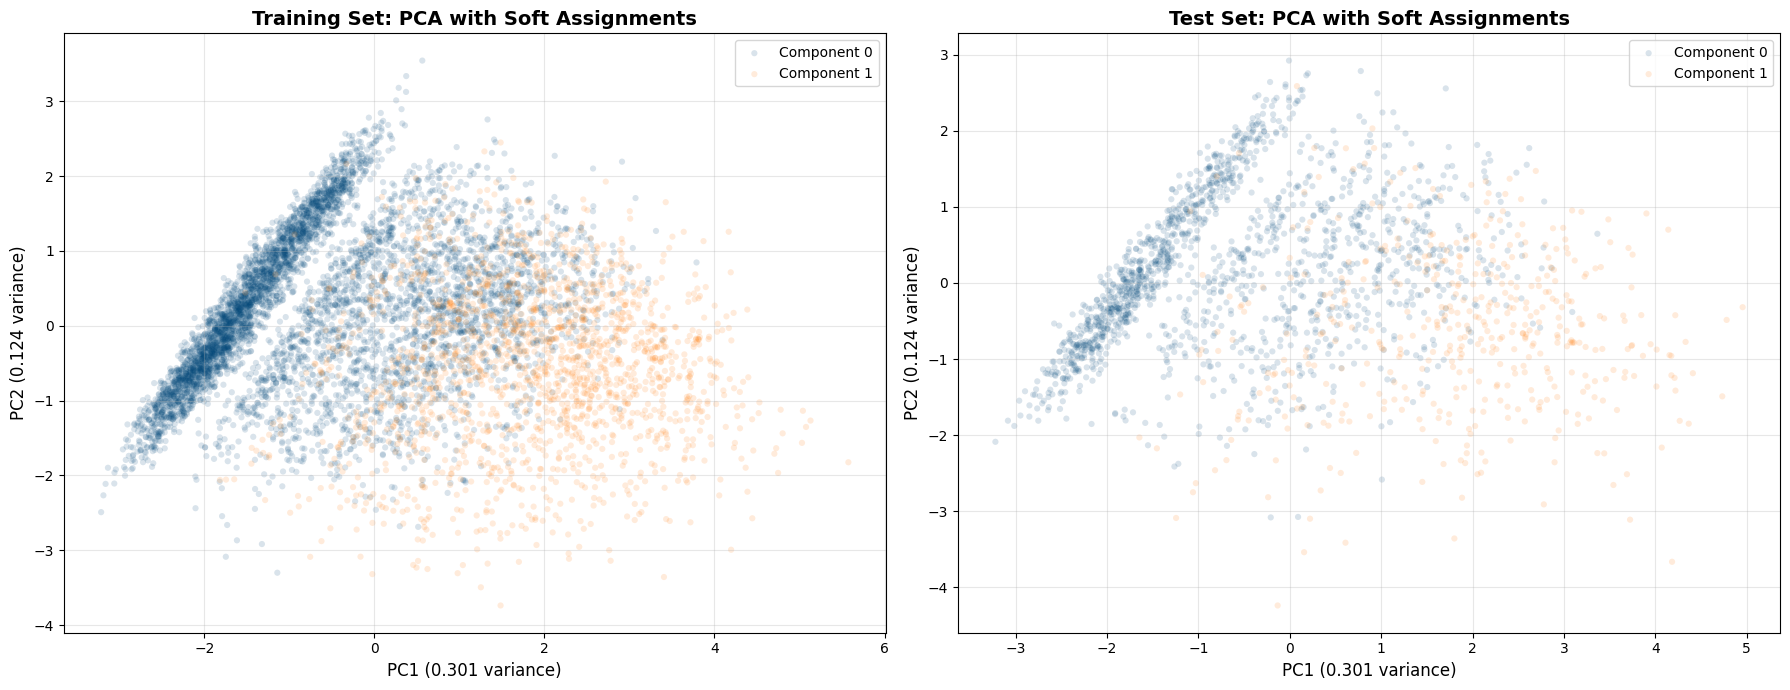


ROC-AUC: 0.7994
PR-AUC:  0.6138


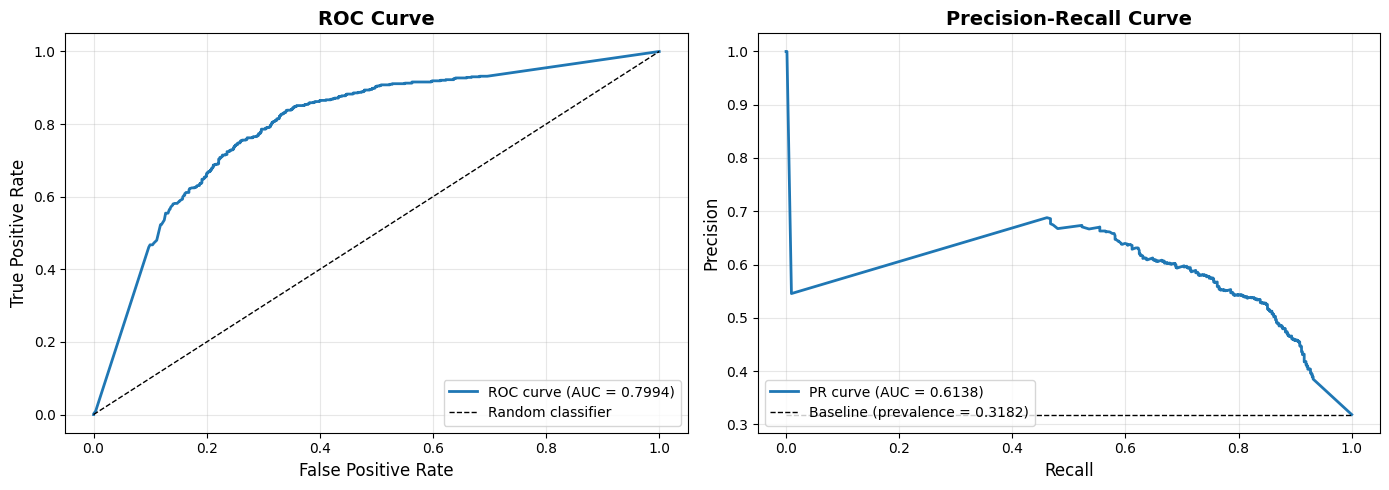

In [ ]:
#n_components = 2
all_results = []
for n_components in [2,3,6,8,10]:
    gmm, train_component_probs, train_components = fit_GMM(
        X_train_scaled, n_components, covariance_type='diag', reg_covariance=1e-6, verbose=False)

    component_claim_probs_hard, component_claim_probs_soft = calculate_component_claim_probabilities(
        y_train, train_component_probs, train_components, n_components, verbose=False)

    y_train_pred_proba, y_val_pred_proba, y_test_pred_proba, test_component_probs = predicted_probabilities(
        gmm, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, component_claim_probs_soft, verbose=False)

        
    soft_train_df = analyze_soft_assignments(train_component_probs, tol=1e-2, n_show=10, verbose=False)
    soft_test_df = analyze_soft_assignments(test_component_probs, tol=1e-2, n_show=10, verbose=False)

    visualize_pca_with_soft_samples(X_train_scaled, X_test_scaled, gmm, soft_train_df, soft_test_df, train_components)

    roc_auc, pr_auc = evaluate_model_performance(y_test, y_test_pred_proba)

    thr_best, val_stats = find_best_threshold(y_val, y_val_pred_proba, metric="f1", verbose=True)
    test_stats = evaluate_at_threshold(y_test, y_test_pred_proba, thr_best, verbose=True)

    all_results.append({
        "K": n_components,
        "thr_best": thr_best,
        "val_stats": val_stats,
        "test_stats": test_stats})
    
summary_df = build_summary_table(all_results, sort_by="TEST_f1", ascending=False)
pd.set_option("display.width", 2000)          
pd.set_option("display.max_columns", None)    # show all columns
pd.set_option("display.expand_frame_repr", False)  # prevent line-wrapping
print(summary_df)

